In [1]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
import math
%matplotlib inline

In [2]:
IMG_PXL_SIZE = 50
HM_SLICES = 20

In [3]:
data_labels = pd.read_csv('stage1_labels.csv',index_col=0)
data_dir = 'C:\\Users\\user\\Downloads\\sample_images\\'
patients = os.listdir(data_dir)
test_patients = pd.read_csv('stage1_sample_submission.csv')

In [36]:
patients

['0015ceb851d7251b8f399e39779d1e7d', '034673134cbef5ea15ff9e0c8090500a']

In [4]:
data_labels

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1
...,...
fe26fd2bb25112b3c2ca93eb8e34f8ed,0
fe45462987bacc32dbc7126119999392,1
fe5c37e82b412833b8ad0abb57978377,0


In [5]:
test_patients

,id,cancer
0,026470d51482c93efc18b9803159c960,0.5
1,031b7ec4fe96a3b035a8196264a8c8c3,0.5
2,03bd22ed5858039af223c04993e9eb22,0.5
3,06a90409e4fcea3e634748b967993531,0.5
4,07b1defcfae5873ee1f03c90255eb170,0.5
...,...,...
193,fb55849cee6473974612c17f094a38cd,0.5
194,fb5874408966d7c6bebd3d84a5599e20,0.5
195,fcfab3eddbdf0421c39f71d651cc5c56,0.5
196,fdcd385b0d2d12341661e1abe845be0b,0.5


In [6]:
test_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      198 non-null    object 
 1   cancer  198 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB


In [7]:
len(patients) 

2

In [8]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [9]:
def mean(l):
    return sum(l)/len(l)

In [10]:
def process_data(patient, data_labels, img_pxl_size=20, hm_slices=20, vizualize = False):

    label = data_labels._get_value(patient,'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PXL_SIZE,IMG_PXL_SIZE)) for each_slice in slices]

    chunk_sizes = math.ceil(len(slices) / HM_SLICES)



    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)


    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val


    if vizualize:
        fig = plt.figure()
        for num,each_slice in enumerate(slices[:12]):
            y = fig.add_subplot(4,5,num+1)

        plt.show()

    if label == 1: label = np.array([0,1])
    elif label == 0: label = np.array([1,0])
    return np.array(new_slices), label

In [11]:
train_data = []

test_data = []

for num, patient in enumerate(patients):
        if num%50 == 0:
            print(num)

        try:
            img_data, label = process_data(patient, data_labels, img_pxl_size=IMG_PXL_SIZE, hm_slices=HM_SLICES)
            train_data.append([img_data,label])
            print(img_data.shape, label)

        except KeyError as e:
            test_data.append([img_data])
            print(img_data.shape , '\tThis is unlabeled data')

np.save('traindata-{}-{}-{}.npy'.format(IMG_PXL_SIZE,IMG_PXL_SIZE,HM_SLICES), train_data)
np.save('testdata-{}-{}-{}.npy'.format(IMG_PXL_SIZE,IMG_PXL_SIZE,HM_SLICES), test_data)
print('Finished processing')

0
(17, 50, 50) [0 1]
(17, 50, 50) 	This is unlabeled data
Finished processing


In [12]:
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [13]:
INPUT_FOLDER = 'C:\\Users\\user\\Downloads\\sample_images\\'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [14]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [15]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0

    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

Text(0, 0.5, 'Frequency')

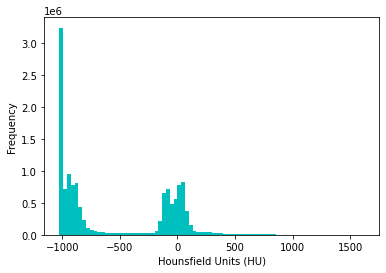

In [16]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

In [17]:

'''
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()
'''

'\nplt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)\nplt.show()\n'

In [18]:
def resample(image, scan, new_spacing=[1,1,1]):
    spacing=np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [19]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (50, 512, 512)
Shape after resampling	 (250, 306, 306)


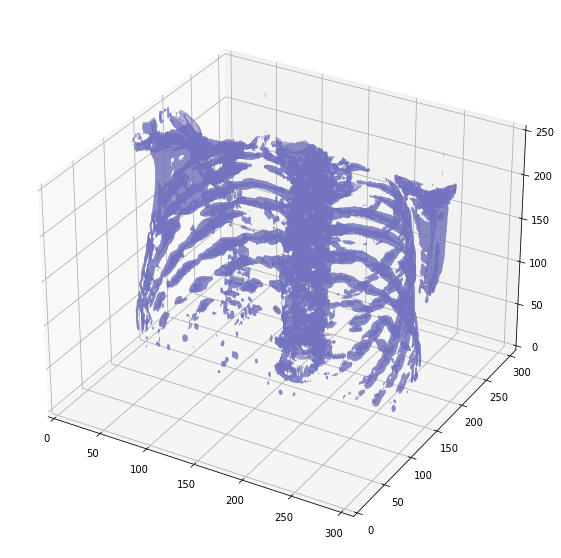

In [20]:
def plot_3d(image, threshold=-300):

   
    p = image.transpose(2,1,0)

    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

plot_3d(pix_resampled, 400)

In [21]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [22]:
def segment_lung_mask(image, fill_lung_structures=True):

    
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    
    background_label = labels[0,0,0]

    
    binary_image[background_label == labels] = 2


    
    if fill_lung_structures:
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)

            if l_max is not None: 
                binary_image[i][labeling != l_max] = 1


    binary_image -= 1 
    binary_image = 1-binary_image 

   
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: 
        binary_image[labels != l_max] = 0

    return binary_image

In [23]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

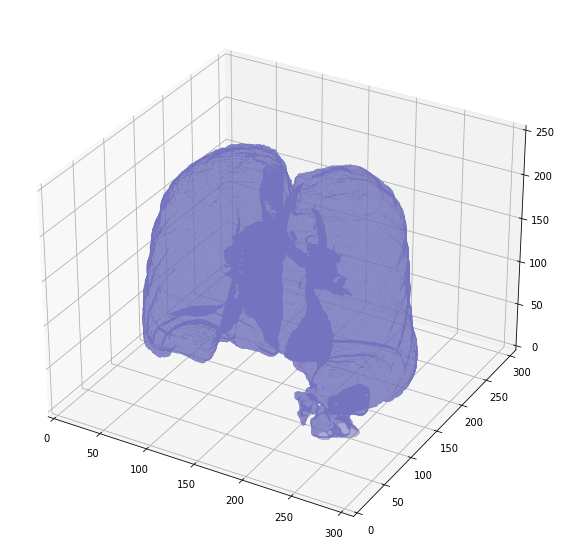

In [24]:
plot_3d(segmented_lungs_fill, 0)

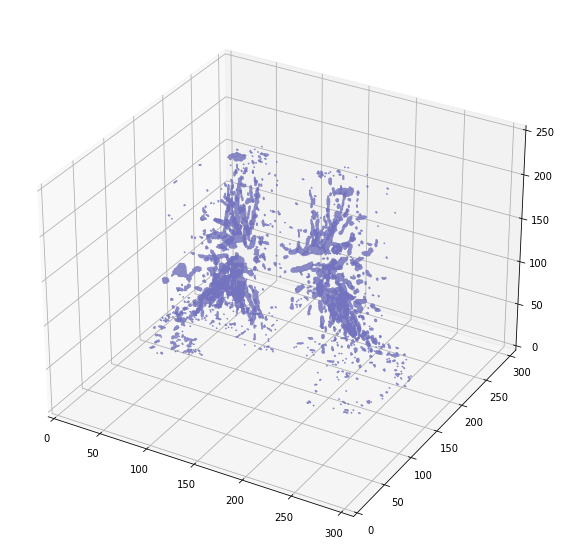

In [25]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)


MIN_BOUND = -1000.0
MAX_BOUND = 400.0

In [26]:
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [27]:
import tensorflow as tf

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\appdata\

In [28]:
IMG_PXL_SIZE = 50
HM_SLICES = 20

In [29]:
n_classes = 2

x = tf.placeholder('float')
y = tf.placeholder('float')

In [30]:
keep_rate = 0.8
keep_prob = tf.placeholder(tf.float32)


In [31]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [32]:
def convolutional_neural_network(x):
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,5,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([5,5,5,32,64])),
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.reshape(x, shape=[-1, IMG_PXL_SIZE, IMG_PXL_SIZE, HM_SLICES, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)

    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)
    

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [37]:
def train_neural_network(x):

    train_data = np.load('traindata-50-50-20.pyn', allow_pickle=True)
    test_data = np.load('testdata-50-50-20.npy', allow_pickle=True)
    
    train = train_data[:1]
    test = train_data[1:]

    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    hm_epochs = 5
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            success_total = 0
            attempt_total = 0
            for data in train:
                attempt_total += 1
                try:

                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    success_total += 1

                except Exception as e:
                    print('Error occured')

            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss, 'success_rate:', success_total/attempt_total)
            
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x: [i[0] for i in test], y: [i[1] for i in test]}))

train_neural_network(x)

FileNotFoundError: [Errno 2] No such file or directory: 'traindata-50-50-20.pyn'